In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns

In [3]:
file = '../data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


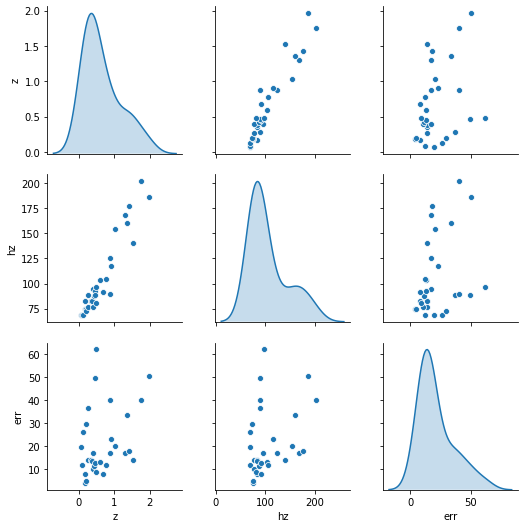

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [5]:
# a = np.array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
#        10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])
# randomize = np.random.permutation(len(data.values))
shuffle = [x for x in range(len(data.values)) if x%2 ==0]
comp = [x for x in range(len(data.values)) if x%2 ==1]
shuffle.extend(comp)

data = data.values[shuffle]
shuffle

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 1,
 3,
 5,
 7,
 9,
 11,
 13,
 15,
 17,
 19,
 21,
 23,
 25,
 27,
 29]

In [6]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [7]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [8]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [9]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = RandomNormal()


In [12]:
# def autoencoder(input_z):
#     #encoder
#     efirst = Dense(100, kernel_initializer=initializer, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, kernel_initializer=initializer, activation='relu')(efirst)
#     elast = Dense(50, kernel_initializer=initializer, activation='relu')(ehidden)
#     #coded
#     coded = Dense(10, kernel_initializer=initializer, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, kernel_initializer=initializer, activation='relu')(coded)
#     dhidden = Dense(50, kernel_initializer=initializer, activation='relu')(dfirst)
#     dlast = Dense(100, kernel_initializer=initializer, activation='relu')(dhidden)
#     decoded = Dense(2, kernel_initializer=initializer, activation='relu')(dlast)
    
#     return decoded

In [13]:
# def autoencoder(input_z):
#     #encoder
#     efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, activation='relu')(efirst)
#     elast = Dense(50, activation='relu')(ehidden)
#     coded = Dense(10, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, activation='relu')(coded)
#     dhidden = Dense(50, activation='relu')(dfirst)
#     dlast = Dense(100, activation='relu')(dhidden)
#     decoded = Dense(2, activation='relu')(dlast)
    
#     return decoded
# def model(input_z):
#     efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(100, activation='relu')(efirst)
#     ehidden = Dense(500, activation='relu')(ehidden)
#     ehidden2 = Dense(500, activation='relu')(ehidden)
#     elast = Dense(2, activation='linear')(ehidden2)
#     return elast

In [14]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    ehidden2 = Dense(150, activation='relu')(ehidden2)
    elast = Dense(2, activation='relu')(ehidden2)


    return elast

batch_size = 16
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 302       
Total params: 73,502
Trainable params: 73,502
Non-trainable params: 0
__________________________________________________

In [15]:
# batch_size = 4
batch_size = 4
epochs = 500
input_z = Input(shape = (1,))

In [16]:
# autoencoder = Model(input_z, autoencoder(input_z))
# autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
# autoencoder.summary()

In [17]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test))
#                                     callbacks=callbacks)

Epoch 1/500
6/6 [==============================] - 0s 22ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 9/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 10/500
6/6 [==============================] - 0s 3ms/step

Epoch 79/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 80/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 81/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 82/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 83/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 84/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 85/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 86/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 87/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 88/500
6/6 [==============================] - 0s 

6/6 [==============================] - 0s 2ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 157/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 158/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 159/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 160/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 161/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 162/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 163/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 164/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 165/500
6/6 [==============================] - 0s 3ms/

6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 234/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 235/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 236/500
6/6 [==============================] - 0s 2ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 237/500
6/6 [==============================] - 0s 2ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 238/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 239/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 240/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 241/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 242/500
6/6 [==============================] - 0s 3ms/

6/6 [==============================] - 0s 2ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 311/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 312/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 313/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 314/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 315/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 316/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 317/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 318/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 319/500
6/6 [==============================] - 0s 3ms/

6/6 [==============================] - 0s 2ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 388/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 389/500
6/6 [==============================] - 0s 2ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 390/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 391/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 392/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 393/500
6/6 [==============================] - 0s 4ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 394/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 395/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 396/500
6/6 [==============================] - 0s 3ms/

6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 465/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 466/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 467/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 468/500
6/6 [==============================] - 0s 4ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 469/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 470/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9346 - val_loss: 11034.5000
Epoch 471/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9341 - val_loss: 11034.5000
Epoch 472/500
6/6 [==============================] - 0s 3ms/step - loss: 5375.9351 - val_loss: 11034.5000
Epoch 473/500
6/6 [==============================] - 0s 3ms/

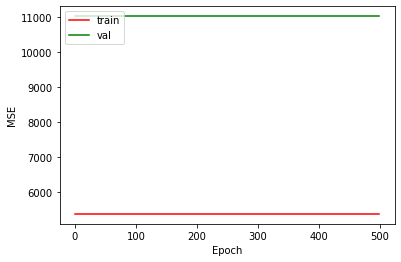

In [18]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_hz.png", dpi=200)


In [19]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
np.min(model_train.history['loss']), np.min(model_train.history['val_loss'])


(5375.93408203125, 11034.5)

In [20]:
pred = neural_model.predict(z_test)
pred

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [21]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [22]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

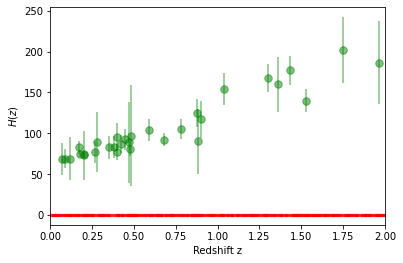

In [23]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
# plt.savefig("more_neurons_HD.png")

In [24]:
# Cosmological constants
Om = 0.27
# variance network


In [25]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

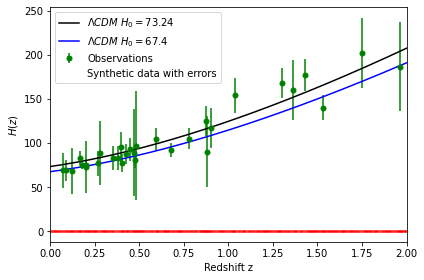

In [26]:
z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

# plt.savefig("SyntheticHDrelu.png",dpi=800)

In [27]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [28]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,100)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [29]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


# np.savetxt("autoEncoderHz100.dat",mookHz, delimiter=" ")

In [30]:
predy_reduced[:,1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [31]:
error  = predy_reduced[:,1]**2
error

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [32]:
diagcov = np.diag(error) #inverso
# np.savetxt("autoEncoderHz_cov100.dat", diagcov, delimiter= " ", header="#100 100")
np.shape(diagcov)

(100, 100)

LinAlgError: singular matrix

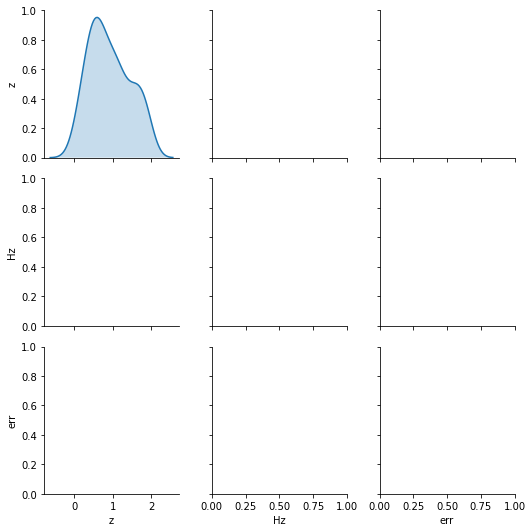

In [33]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("100hdmook.png")